# 3D Point Cloud Clustering with K-means and DBSCAN and Python

Inside this notebook we will use K-Means for a radiometric clustering useing the HSV-information.<br>
Next up we will use DBSCAN to create a spatial clustering using the coordinates.

The goal of this notebook is to export some of the spatial clusters in order to create training-data for a Random Forest classification.

<b>This Jupyter-Notebook is part of a master thesis with the topic<br>
<i>Analysis of deep learning methods for semantic segmentation of photogrammetric point clouds from aerial images</i><br>
&copy; Markus Hülsen, Matr.-Nr. 6026370<br>
Date: 15.08.2023</b>

## Setting up 3D Python Context
Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import laspy
import os
import pandas as pd
from tqdm.notebook import tqdm 
import random

## Import Data
Data is stored as `LAS`-file. We will use `laspy` to import und convert the data.<br>
First we create a function to import an `LAS`-File and convert them into a Pandas `DataFrame`.

In [2]:
def import_las_to_Dataframe(path):
    with laspy.open(path) as f:
        las = f.read()
    
    # read coordinates from las
    x = np.array(las.x)
    y = np.array(las.y)
    z = np.array(las.z)

    df = pd.DataFrame({'X':x,'Y':y,'Z':z},index=np.arange(len(x)))

    for i in range(3, len(las.point_format.dimensions)):
        dim = las.point_format.dimensions[i].name
        df[dim] = np.array(las[dim])
     
    return df

Express path where the data is stored, that we want to processed. <br>All `las`-Files inside the defined folder will be stored in a list.

In [3]:
# path where the data ist stored
data_path = '../../Daten/Datensatz_H3D/'
# sub-folder which includes different acquisition dates and types like 'DIM_2016', 'DIM_2019', 'DIM_2022', 'ALS2016', ...
data = 'DIM_2022/6 - KMeans 2/classified'

# save files that are in laz-format
lst_files = []
for file in os.listdir(data_path + data):
    
    # Add Label 9 and label 11 to the list
    if file.endswith('.las'):
        lst_files.append(data_path + data + '/' + file)
lst_files = sorted(lst_files)
print('Found',len(lst_files),'las-files:')
print(lst_files)

Found 1 las-files:
['../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified556000_5801000.las']


Use function above to read the point cloud and convert it to pandas DataFrame.

In [4]:
# define file we want to use
las_path = lst_files[0]
las_path

'../../Daten/Datensatz_H3D/DIM_2022/6 - KMeans 2/classified/classified556000_5801000.las'

In [5]:
# import data
df = import_las_to_Dataframe(las_path)

df

,X,Y,Z,intensity,return_number,number_of_returns,scan_direction_flag,edge_of_flight_line,classification,synthetic,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_ground,count_veg
0,556716.13,5801016.48,93.27,8557,1,1,0,0,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.815487,NaN,NaN
1,556715.31,5801015.83,92.52,17719,1,2,0,0,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.096548,NaN,NaN
2,556715.80,5801015.81,93.38,14610,1,1,0,0,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.950687,NaN,NaN
3,556715.54,5801016.19,93.12,7424,1,2,0,0,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.689709,NaN,NaN
4,556715.51,5801016.64,93.14,6295,1,1,0,0,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.699112,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5441834,556963.29,5801560.73,67.88,16870,1,7,0,0,8,1,...,0.0,0.381305,0.614308,0.364619,-11.232155,0.014979,14.0,0.596580,88.0,7.0
5441835,556934.55,5801576.58,68.17,8886,1,1,0,0,8,1,...,0.0,0.225938,0.287983,0.694332,-2.695607,0.010224,14.0,0.776917,91.0,1.0
5441836,556987.04,5801565.76,68.27,16573,1,7,0,0,8,1,...,0.0,0.244988,0.218660,0.758269,-3.670811,0.012786,14.0,1.041296,97.0,0.0
5441837,556973.90,5801574.79,67.69,14991,1,1,0,0,8,1,...,0.0,0.117942,0.665683,0.332407,-12.185335,0.001429,14.0,0.510102,94.0,3.0


## Datapreparation
Some of the features are not necessary/redudant. We will remove them.

In [6]:
print('Attribute:')
for column in df:
    if len(pd.unique(df[column])) == 1:
        print(str(column) + (25 - len(str(column))) * ' '  + 'contains just a single value and will be returned!')
        df = df.drop(column, axis=1)
    else:
        print(str(column) +  (25 - len(str(column))) * ' '  + 'will be maintained')

df

Attribute:
X                        will be maintained
Y                        will be maintained
Z                        will be maintained
intensity                will be maintained
return_number            contains just a single value and will be returned!
number_of_returns        will be maintained
scan_direction_flag      contains just a single value and will be returned!
edge_of_flight_line      contains just a single value and will be returned!
classification           will be maintained
synthetic                will be maintained
key_point                contains just a single value and will be returned!
withheld                 contains just a single value and will be returned!
scan_angle_rank          will be maintained
user_data                will be maintained
point_source_id          contains just a single value and will be returned!
gps_time                 contains just a single value and will be returned!
red                      will be maintained
green            

,X,Y,Z,intensity,number_of_returns,classification,synthetic,scan_angle_rank,user_data,red,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_ground,count_veg
0,556716.13,5801016.48,93.27,8557,1,8,1,0,113,29952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.815487,NaN,NaN
1,556715.31,5801015.83,92.52,17719,2,8,1,0,105,51968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.096548,NaN,NaN
2,556715.80,5801015.81,93.38,14610,1,8,1,0,103,36096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.950687,NaN,NaN
3,556715.54,5801016.19,93.12,7424,2,8,1,0,113,50176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.689709,NaN,NaN
4,556715.51,5801016.64,93.14,6295,1,8,1,0,122,54784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.699112,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5441834,556963.29,5801560.73,67.88,16870,7,8,1,0,143,14592,...,0.0,0.381305,0.614308,0.364619,-11.232155,0.014979,14.0,0.596580,88.0,7.0
5441835,556934.55,5801576.58,68.17,8886,1,8,1,0,139,16896,...,0.0,0.225938,0.287983,0.694332,-2.695607,0.010224,14.0,0.776917,91.0,1.0
5441836,556987.04,5801565.76,68.27,16573,7,8,1,0,183,16384,...,0.0,0.244988,0.218660,0.758269,-3.670811,0.012786,14.0,1.041296,97.0,0.0
5441837,556973.90,5801574.79,67.69,14991,1,8,1,0,122,16384,...,0.0,0.117942,0.665683,0.332407,-12.185335,0.001429,14.0,0.510102,94.0,3.0


## Point Cloud Filtering

### Reduce area of the Pointcloud
Because the pointcloud contains to many points we will look in area with 100m x 100m.

In [7]:
# Bounding Box
bbox_x1 = df.X.min()
bbox_y1 = df.Y.min()
bbox_x2 = (df.X.max() + df.X.min())
bbox_y2 = (df.Y.max() + df.Y.min())

# Select Point inside of Bounding Box
df_sub = df.loc[(df.X >= bbox_x1) & (df.Y >= bbox_y1) & (df.X <= bbox_x2) & (df.Y <= bbox_y2)]

print('Check Results')
print('X min:', df_sub.X.min(), 'X max:', df_sub.X.max())
print('Y min:', df_sub.Y.min(), 'Y max:', df_sub.Y.max())

df_sub

Check Results
X min: 556000.0 X max: 556999.96
Y min: 5800999.75 Y max: 5801999.74


,X,Y,Z,intensity,number_of_returns,classification,synthetic,scan_angle_rank,user_data,red,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_ground,count_veg
0,556716.13,5801016.48,93.27,8557,1,8,1,0,113,29952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.815487,NaN,NaN
1,556715.31,5801015.83,92.52,17719,2,8,1,0,105,51968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.096548,NaN,NaN
2,556715.80,5801015.81,93.38,14610,1,8,1,0,103,36096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.950687,NaN,NaN
3,556715.54,5801016.19,93.12,7424,2,8,1,0,113,50176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.689709,NaN,NaN
4,556715.51,5801016.64,93.14,6295,1,8,1,0,122,54784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.699112,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5441834,556963.29,5801560.73,67.88,16870,7,8,1,0,143,14592,...,0.0,0.381305,0.614308,0.364619,-11.232155,0.014979,14.0,0.596580,88.0,7.0
5441835,556934.55,5801576.58,68.17,8886,1,8,1,0,139,16896,...,0.0,0.225938,0.287983,0.694332,-2.695607,0.010224,14.0,0.776917,91.0,1.0
5441836,556987.04,5801565.76,68.27,16573,7,8,1,0,183,16384,...,0.0,0.244988,0.218660,0.758269,-3.670811,0.012786,14.0,1.041296,97.0,0.0
5441837,556973.90,5801574.79,67.69,14991,1,8,1,0,122,16384,...,0.0,0.117942,0.665683,0.332407,-12.185335,0.001429,14.0,0.510102,94.0,3.0


### Just consider classes `Not-Ground` and `humanmade`
Class 'not ground' is defined by `13` and 'humanmade' by `40`

In [8]:
df_not_ground = df_sub.loc[(df_sub.classification == 13) | (df_sub.classification == 40)].drop('classification', axis=1)
df_not_ground

,X,Y,Z,intensity,number_of_returns,synthetic,scan_angle_rank,user_data,red,green,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_ground,count_veg
5304679,556109.56,5801110.08,72.80,9391,2,0,0,115,7168,12800,...,13.0,1.245513,0.340846,0.447790,-3.964344,0.112998,0.0,7.067183,0.0,12.0
5304680,556109.30,5801108.79,72.00,9392,1,0,0,125,7680,13312,...,16.0,1.049257,-2.940594,1.350998,-3.391250,0.343895,0.0,6.282714,0.0,14.0
5304681,556109.26,5801110.88,69.41,8359,2,0,0,122,7424,13056,...,16.0,1.098759,0.409350,0.408242,-2.996578,0.102878,0.0,3.702595,0.0,9.0
5304682,556097.25,5801151.65,70.54,9355,2,0,0,64,10240,15104,...,13.0,1.706990,-0.696121,-0.226014,-6.556703,0.416204,0.0,3.913671,14.0,15.0
5304683,556061.74,5801045.56,66.15,9426,3,0,0,205,6656,11776,...,13.0,1.319072,-10.160110,2.537215,-9.381673,0.414901,0.0,1.674893,34.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5431541,556977.47,5801613.52,68.01,7511,5,0,0,120,24576,19712,...,0.0,0.923005,0.552755,0.324670,-1.655811,0.078082,0.0,2.478839,23.0,41.0
5431542,556965.27,5801653.82,65.65,7534,2,0,0,150,54272,52736,...,0.0,0.310774,0.303687,0.640036,-0.737348,0.032111,0.0,1.095831,28.0,38.0
5431543,556981.51,5801607.71,67.47,7512,5,0,0,120,16896,16896,...,2.0,0.648180,0.715744,-0.468420,-0.275114,0.369514,0.0,1.802451,28.0,35.0
5431544,556980.59,5801607.36,67.41,7512,4,0,0,120,18176,16896,...,0.0,0.584067,0.816227,-0.304239,-0.625790,0.291911,0.0,1.714981,19.0,51.0


## Update the count-attribute
After we have made another classification with K-Means, we need to update the attributes `count_building`, `count_veg` and `count_ground`.

### Define KD-Tree

In [9]:
from sklearn.neighbors import KDTree

In [10]:
# points
X = df_sub.loc[:,'X':'Z']

#number of nearest neighbors
K=100

kdt = KDTree(X, leaf_size=40, metric='euclidean')
dist, indices = kdt.query(X, k=K, return_distance=True)

print('Indices:\n', indices)
print()
print('Distances:\n', dist)

Indices:
 [[      0       5       4 ...      74      78      68]
 [      1       3       2 ...      39      74      78]
 [      2       3       0 ...      74      25      32]
 ...
 [5441836 3311016 5402951 ... 3312018 3312844 3310384]
 [5441837 1258471 1258519 ... 3313525 3312262 3313558]
 [5441838 3312742 3311705 ... 3310492 3311925 3314160]]

Distances:
 [[ 0.          0.36959437  0.65337585 ... 12.04711584 12.16469071
  12.17563961]
 [ 0.          0.73654599  0.99       ... 12.02684913 12.043081
  12.07948261]
 [ 0.          0.52877216  0.75491721 ... 12.36856095 12.44150312
  12.4469193 ]
 ...
 [ 0.          0.90166513  0.93069866 ...  3.31956322  3.33286663
   3.33691474]
 [ 0.          0.20904545  0.25258662 ...  5.18330011  5.18588469
   5.19078029]
 [ 0.          0.4796874   0.5745433  ...  4.00500936  4.01082286
   4.01722541]]


#### Calculate hoe often the classes `vegetation`, `building` and `ground` occurs.

Estimate the positions of the classes 13 and 40

In [11]:
# Estimate position of points with class = 13
position = df_sub.reset_index().loc[(df_sub.reset_index().classification == 13) | (df_sub.reset_index().classification == 40)].index.to_numpy()
position

array([5304679, 5304680, 5304681, ..., 5431543, 5431544, 5431545])

Get the labels of the neighboring-points

In [12]:
labels = df_sub.classification.to_numpy()[indices][position]
labels

array([[13, 13, 13, ...,  6, 20, 13],
       [13, 13, 13, ...,  6, 13,  6],
       [13, 13, 13, ..., 13, 13,  6],
       ...,
       [13, 13, 13, ..., 20,  2,  2],
       [13, 13, 20, ..., 20,  2,  2],
       [13, 20, 20, ..., 13, 20,  2]], dtype=uint8)

Count how often the label `vegetation` occurs.

In [13]:
build_count = np.sum(labels == 6, axis=1)

print('Label "building" occurs', build_count, 'in the neighborhoods.')
print(len(build_count))

Label "building" occurs [20 23 24 ...  6  0 10] in the neighborhoods.
126867


Count how often the label `building` occurs. 

In [14]:
veg_count = np.sum(labels == 20, axis=1)

print('Label "vegetation" occurs', veg_count, 'in the neighborhoods.')
print(len(veg_count))

Label "vegetation" occurs [36 40 37 ... 55 70 67] in the neighborhoods.
126867


Count how often the label `ground` occurs.

In [15]:
ground_count = np.sum(labels == 2, axis=1)

print('Label "ground" occurs', ground_count, 'in the neighborhoods.')
print(len(veg_count))

Label "ground" occurs [ 0  0  0 ... 28 19  1] in the neighborhoods.
126867


Add results to DataFrame

In [16]:
df_not_ground['count_veg'] = veg_count
df_not_ground['count_building'] = build_count
df_not_ground['count_ground'] = ground_count

df_not_ground.loc[:, ['count_veg', 'count_building', 'count_ground']]

,count_veg,count_building,count_ground
5304679,36,20,0
5304680,40,23,0
5304681,37,24,0
5304682,70,13,14
5304683,42,14,34
...,...,...,...
5431541,52,0,23
5431542,40,0,28
5431543,55,6,28
5431544,70,0,19


## Cluster by Color with K-Means
First we want to cluster our pointcloud by the color, using the HSV-colorspace.build_count = np.sum(labels == 6, axis=1)

print('Label "building" occurs', build_count, 'in the neighborhoods.')
print(len(build_count))

In [17]:
import colorsys

Get color in RGB, normalize them and change the colorspace

In [18]:
r, g, b = df_not_ground.loc[:, 'red':'blue'].to_numpy().T
r, g ,b = (r/256).astype('uint8'), (g/256).astype('uint8'), (b/256).astype('uint8')
rgb = np.array([r,g,b]).T / 256

hsv_norm = np.apply_along_axis(lambda x: colorsys.rgb_to_hsv(*x), -1, rgb)
hsv_norm

array([[0.52      , 0.47169811, 0.20703125],
       [0.54022989, 0.49152542, 0.23046875],
       [0.5308642 , 0.48214286, 0.21875   ],
       ...,
       [0.        , 0.        , 0.2578125 ],
       [0.83333333, 0.07042254, 0.27734375],
       [0.75      , 0.05128205, 0.3046875 ]])

Add HSV-Colors to the DataFrame

In [19]:
color = pd.DataFrame(hsv_norm, index=df_not_ground.index, columns=['Hue', 'Saturation', 'Value'])
df_not_ground.loc[:, 'Hue': 'Value'] = hsv_norm
color

,Hue,Saturation,Value
5304679,0.520000,0.471698,0.207031
5304680,0.540230,0.491525,0.230469
5304681,0.530864,0.482143,0.218750
5304682,0.561111,0.428571,0.273438
5304683,0.533333,0.490196,0.199219
...,...,...,...
5431541,0.973684,0.197917,0.375000
5431542,0.075758,0.051887,0.828125
5431543,0.000000,0.000000,0.257812
5431544,0.833333,0.070423,0.277344


Seperate the colors in `inside_road` and `outside_road`

In [20]:
color_inside = color.loc[df_not_ground.inside_road == 1]
color_outside = color.loc[(df_not_ground.inside_road != 1)]

Use MinMaxScaler to scale our features.

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
color_inside_scaled = MinMaxScaler().fit_transform(color_inside.to_numpy())
color_inside_scaled

array([[0.37549669, 0.04221233, 0.4741784 ],
       [0.33377483, 0.04715909, 0.55399061],
       [0.39635762, 0.08562218, 0.46478873],
       ...,
       [0.        , 0.        , 0.85446009],
       [0.11682119, 0.11346548, 0.42723005],
       [0.1192053 , 0.06904337, 0.52112676]])

In [23]:
color_outside_scaled = MinMaxScaler().fit_transform(color_outside.to_numpy())
color_outside_scaled

array([[0.52094374, 0.68362045, 0.07476636],
       [0.54121034, 0.71235569, 0.10280374],
       [0.53182765, 0.69875776, 0.08878505],
       ...,
       [0.        , 0.        , 0.13551402],
       [0.83484574, 0.10206165, 0.1588785 ],
       [0.75136116, 0.07432181, 0.19158879]])

### Implementation of KMeans

In [24]:
K = 6
kmeans_inside = KMeans(n_clusters=K, init='k-means++', random_state = 42)
kmeans_outside = KMeans(n_clusters=K, init='k-means++', random_state = 42)

In [25]:
kmeans_inside.fit(color_inside_scaled)
kmeans_outside.fit(color_outside_scaled)

labels_inside = kmeans_inside.labels_ + K
labels_outside = kmeans_outside.labels_

/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/markus/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Visulaize a histogram of the clusters, to see how often each cluster occurs.

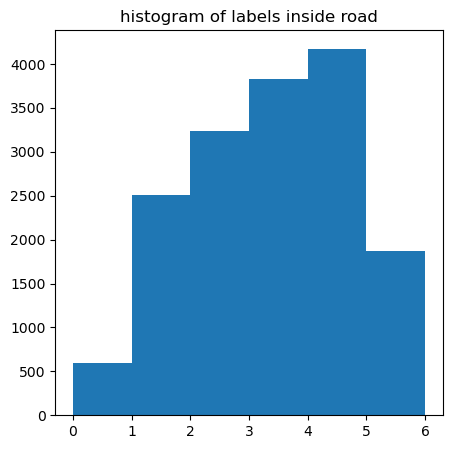

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(labels_inside - K, bins = np.arange(0, K+1))
ax.set_title("histogram of labels inside road")
ax.set_xticks(np.arange(0, K+1))
plt.show()

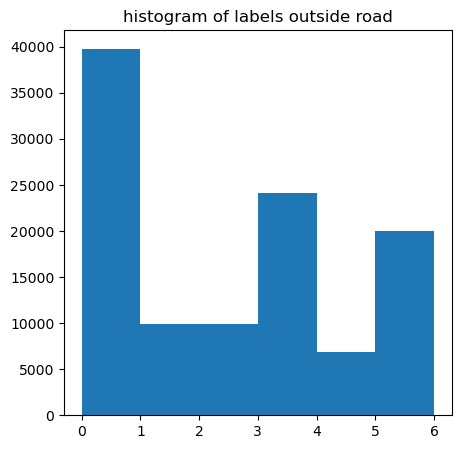

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hist(labels_outside, bins = np.arange(0, K+1))
ax.set_title("histogram of labels outside road")
ax.set_xticks(np.arange(0, K+1))
plt.show()

Add results to DataFrame

In [28]:
df_not_ground.loc[color_inside.index,'label'] = labels_inside
df_not_ground.loc[color_outside.index,'label'] = labels_outside

print('Existing clusters in DataFrame:\n', sorted(df_not_ground['label'].unique()))

Existing clusters in DataFrame:
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]


Visualize Scatter plot of the KMeans clustering

In [29]:
classes, counts = np.unique(df_not_ground['label'], return_counts=True)

# add labels to the DataFrame
XYZ = df_not_ground.loc[:,['X', 'Y', 'Z', 'label']]
XYZ

,X,Y,Z,label
5304679,556109.56,5801110.08,72.80,0.0
5304680,556109.30,5801108.79,72.00,0.0
5304681,556109.26,5801110.88,69.41,0.0
5304682,556097.25,5801151.65,70.54,3.0
5304683,556061.74,5801045.56,66.15,0.0
...,...,...,...,...
5431541,556977.47,5801613.52,68.01,5.0
5431542,556965.27,5801653.82,65.65,2.0
5431543,556981.51,5801607.71,67.47,1.0
5431544,556980.59,5801607.36,67.41,5.0


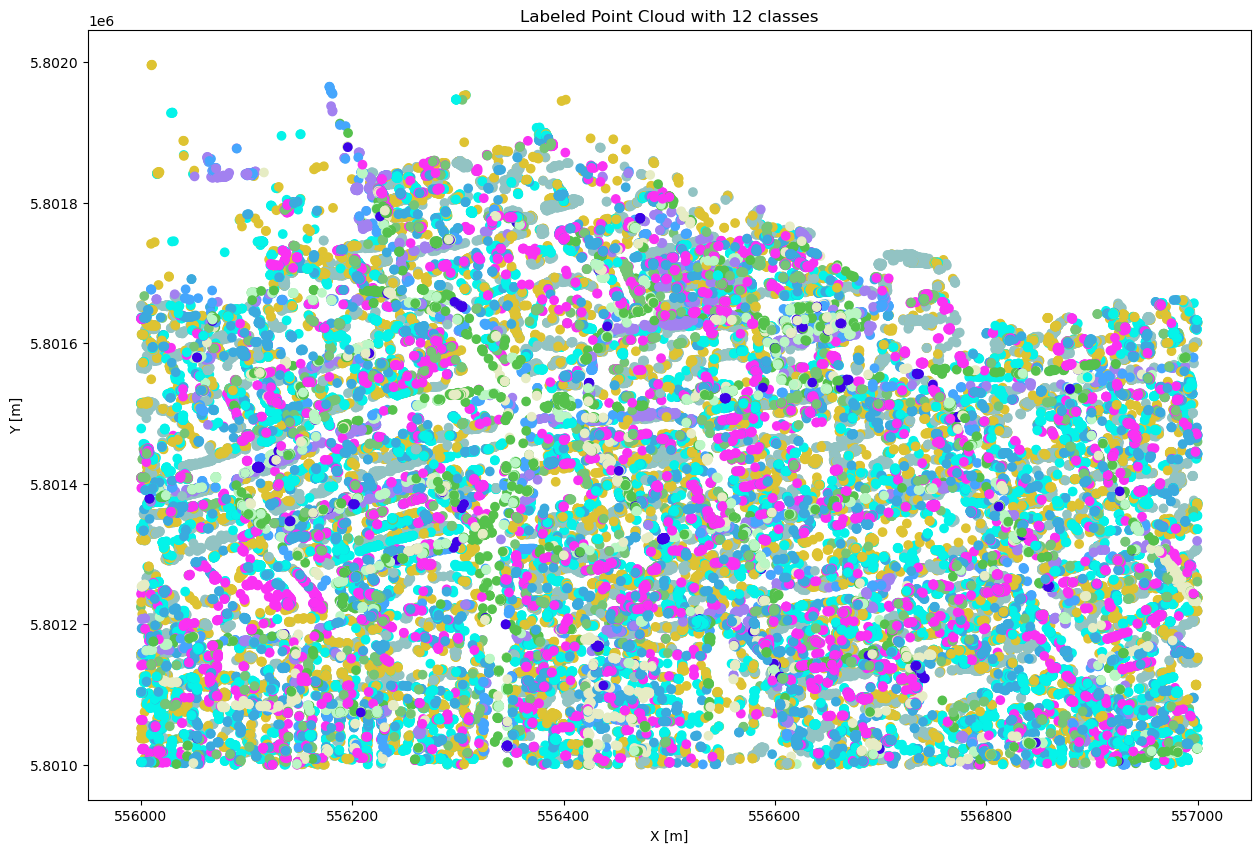

In [30]:
# Define random colors for each class
class_colors = {c: f'#{random.randint(0, 0xFFFFFF):06x}' for c in classes}

# Set the figure size
plt.figure(figsize=(15, 10))  # Adjust the width and height as desired

# Plot the points with colors corresponding to their classes
plt.scatter(XYZ['X'], XYZ['Y'], c=XYZ['label'].map(class_colors))
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Labeled Point Cloud with ' + str(len(classes)) + ' classes')
plt.show()

## Implementation of DBScan

Get unique labels of KMeans clustering

In [31]:
labels_kmeans = sorted(XYZ.label.unique())
labels_kmeans

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

Define export path

In [32]:
file = las_path.split('/')[-1].replace('.las', '')
path = (data_path + data).replace('/6 - KMeans 2/classified', '/7 - DBScan/')
path

'../../Daten/Datensatz_H3D/DIM_2022/7 - DBScan/'

Create folder to store the data.

In [33]:
if not os.path.isdir(path + file):
    os.makedirs(path + file)
    print('created new folder', path + file)
else:
    print(path + file, 'already exists')

../../Daten/Datensatz_H3D/DIM_2022/7 - DBScan/classified556000_5801000 already exists


Function to export a DataFrame as las-file.

In [34]:
def save_df_to_las(df, path):
    
    header = laspy.LasHeader(point_format=3, version="1.2")
    
    atts = []
    for dim in header.point_format.dimensions:
        atts.append(dim.name)
    
    for dim in df.columns:
        if dim not in atts:
            header.add_extra_dim(laspy.ExtraBytesParams(name=dim, type=np.float32))
    
    las_new = laspy.LasData(header)

    las_new.x = df.X.to_numpy()
    las_new.y = df.Y.to_numpy()
    las_new.z = df.Z.to_numpy()
    
    for col in df.loc[:,'intensity':].columns:
        las_new[col] = df[col].to_numpy()
    
    las_new.write(path)

First lets try DBScan on the first cluster and visualize the results.

Number of noise points: 1629


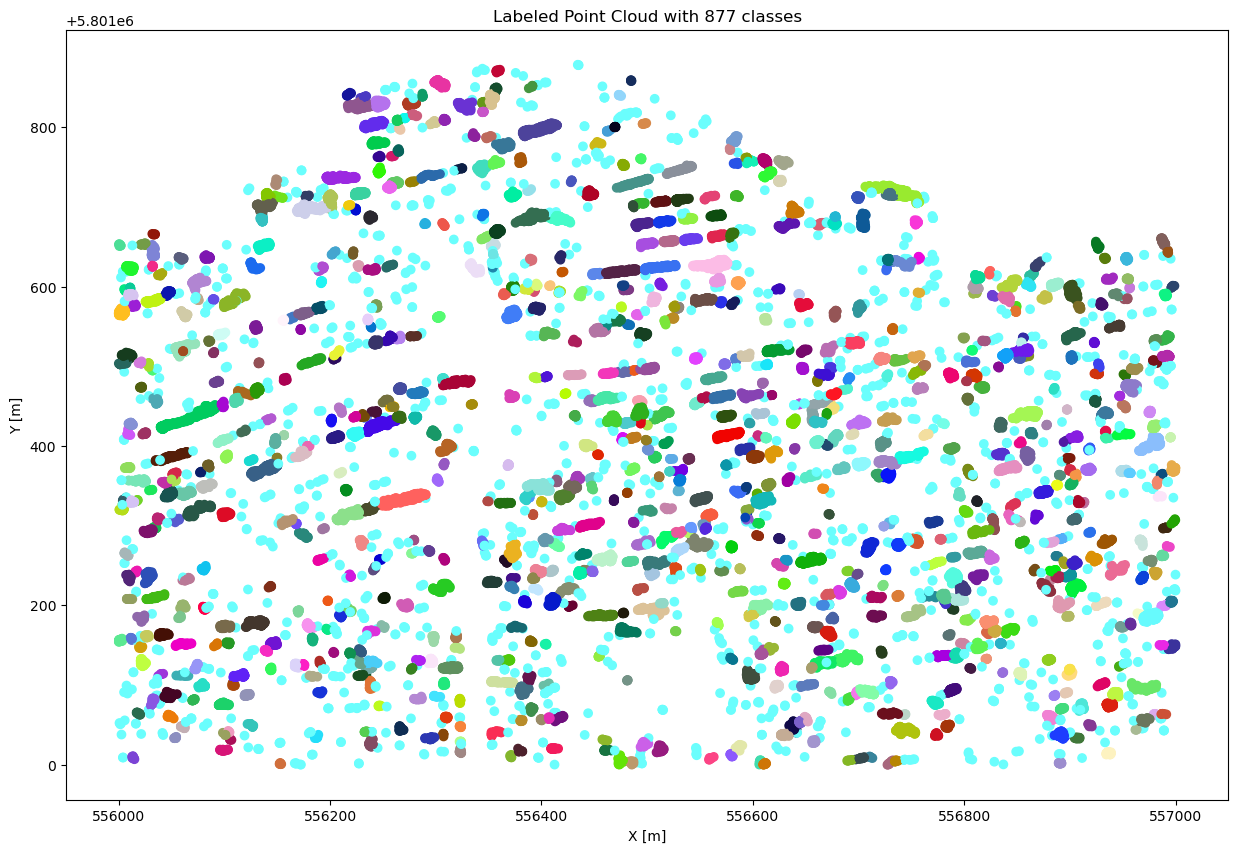

In [35]:
X = XYZ.loc[XYZ.label == 0, 'X':'Z']
clustering = DBSCAN(eps=3.8, min_samples=5).fit(X)
cluster = clustering.labels_
classes, counts = np.unique(cluster, return_counts=True)

print('Number of noise points:',counts[0])
# add labels to the DataFrame
X['class'] = cluster

# Define random colors for each class
class_colors = {c: f'#{random.randint(0, 0xFFFFFF):06x}' for c in classes}

# Set the figure size
plt.figure(figsize=(15, 10))  # Adjust the width and height as desired

# Plot the points with colors corresponding to their classes
plt.scatter(X['X'], X['Y'], c=X['class'].map(class_colors))
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Labeled Point Cloud with ' + str(len(classes)) + ' classes')
plt.show()

if there are `NaN` values inside of the attribute `inside_road`, replace them with 0

In [36]:
df_not_ground.loc[df_not_ground.inside_road.isna(),'inside_road'] = 0
df_not_ground[df_not_ground.isna().any(axis=1)]

,X,Y,Z,intensity,number_of_returns,synthetic,scan_angle_rank,user_data,red,green,...,count_building,std_z,linearity,planarity,eigenentropy,curvature change,label,z_to_dem,count_ground,count_veg


Use DBScan for every color-cluster to get euclidian clusters in a metric room

In [37]:
for cluster in tqdm(labels_kmeans):
    X = XYZ.loc[XYZ.label == cluster, 'X':'Z']
    clustering = DBSCAN(eps=3.8, min_samples=5).fit(X)
    labels = clustering.labels_
    X.loc[:,'cluster'] = labels
    
    # define export path
    ex_path = path + file + '/cluster_' + str(cluster)
    
    # create folder
    if not os.path.isdir(ex_path):
        os.makedirs(ex_path)
    
    # export the first 50 clusters
    for i in range(50):
        classes = sorted(X['cluster'].unique())
        if i >= len(classes):
            continue
        label = classes[i]
        ind_export = X.loc[X.cluster == label].index
        X_export = df_not_ground.loc[ind_export, :]
        save_df_to_las(X_export, ex_path + '/label_' + str(label) + '.las')


  0%|          | 0/12 [00:00<?, ?it/s]

Now the spatial clusters are exported and we need to annotate them manualy.<br>
If we are done with that, we can continue with the notebook `Analyse_Clusters.ipynb`